In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker
%matplotlib inline

In [2]:
datFileName = "../data/processedSaps-new.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ')
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
sapsDataDF = pandas.concat( [ sapsDataDF, \
                    pandas.cut( sapsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
sapsDataDF.columns = [ ["dateStr", "hour","sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat",\
                     "poesMLT", "dst_date", "dst_index", "time", "dst_bin"] ]
sapsDataDF = sapsDataDF.drop(["radId", "poesLat", "poesMLT", "dst_date", "hour"], 1)
sapsDataDF.head()

,dateStr,sapsLat,sapsMLT,sapsVel,dst_index,time,dst_bin
0,20110107,56.5,17.7543,308.2077,-18.0,0,"(-25, -10]"
1,20110107,55.5,18.0147,224.1588,-18.0,0,"(-25, -10]"
2,20110107,56.5,17.8749,307.4328,-18.0,0,"(-25, -10]"
3,20110107,55.5,18.1324,222.4787,-18.0,0,"(-25, -10]"
4,20110107,56.5,17.9955,305.4201,-18.0,0,"(-25, -10]"


In [3]:
# Calculate the median dst in each dst bin
dstBinMedians = sapsDataDF.groupby(["dst_bin"]).median()
dstBinMedians = dstBinMedians.drop(["dateStr", "sapsLat", "sapsMLT", \
                                "sapsVel", "time"], 1)
dstBinMedians["dst_bin"] = dstBinMedians.index
dstBinMedians.reset_index(drop=True, inplace=True)
dstBinMedians.columns = [ "dst_median", "dst_bin" ]
dstBinMedians.head()

,dst_median,dst_bin
0,-95.0,"(-150, -75]"
1,-57.0,"(-75, -50]"
2,-36.0,"(-50, -25]"
3,-18.0,"(-25, -10]"
4,-5.0,"(-10, 10]"


In [4]:
def chngMLTs(row):
    if ( (row["sapsMLT"] >= 23.3) ):
        return 0.
    elif ( (row["sapsMLT"] >= 0.) & (row["sapsMLT"] <= 0.6) ):
        return 0.
    else:
        return round(row["sapsMLT"])

In [5]:
# calculate prob of occ by dst_bin, MLT, Lat
# sapsDataDF["sapsMLTRounded"] = sapsDataDF["sapsMLT"].map(lambda x: round(x) % 24.)
sapsDataDF["sapsMLTRounded"] = sapsDataDF.apply( chngMLTs, axis=1 )
# get a normalized form of MLT where 
# if MLT > 12: MLT = MLT - 24, else MLT = MLT
# sapsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in sapsDataDF['sapsMLTRounded']]
# sapsDataDF['normLAT'] = [x-57.5 for x in sapsDataDF['sapsLat']]
# Get max points at a given Lat, MLT, DstBin
dstGrps = sapsDataDF.groupby(["dst_bin", "sapsMLTRounded", "sapsLat"])
dstSapsMLTLatCountDF = pandas.DataFrame( dstGrps["sapsVel"].count() ).reset_index()
maxCntMLTLatDst = dstSapsMLTLatCountDF.groupby(["dst_bin"]).max().reset_index()
maxCntMLTLatDst = maxCntMLTLatDst.drop(["sapsMLTRounded", "sapsLat"], 1)
maxCntMLTLatDst.columns = ["dst_bin", "maxCount"]
dstSapsMLTLatCountDF = pandas.merge( dstSapsMLTLatCountDF, maxCntMLTLatDst, \
                              on=["dst_bin"], how='inner')
dstSapsMLTLatCountDF.columns = ["dst_bin", "sapsMLT", "sapsLat", "dataCount", "maxCount"]
dstSapsMLTLatCountDF["MLT"] = dstSapsMLTLatCountDF["sapsMLT"].map(lambda x: str(int(x)) )
dstSapsMLTLatCountDF["probOcc"] = dstSapsMLTLatCountDF["dataCount"]/dstSapsMLTLatCountDF["maxCount"]
# Also assign a median dst value for each dst bin
dstSapsMLTLatCountDF = pandas.merge( dstBinMedians, dstSapsMLTLatCountDF, on = "dst_bin")

In [6]:
sapsModelDF = pandas.DataFrame(columns=["sapsMLT", "sapsLat", "probSAPS", "dataCount",\
                                        "maxCount", "MLT", "Lat","dst_bin", "dst_median"])
latArr = []
mltArr = []
dstBinArr = []
dstMedArr = []
for z in range( len( dstSapsMLTLatCountDF["dst_bin"].unique() ) ):
    for x in range( int(dstSapsMLTLatCountDF["sapsLat"].min()), int(dstSapsMLTLatCountDF["sapsLat"].max()) + 1 ):
        for y in range( int(dstSapsMLTLatCountDF["sapsMLT"].min()), int(dstSapsMLTLatCountDF["sapsMLT"].max()) ):
            latArr.append( x + .5 ) # Note all our lats are like 50.5 etc
            mltArr.append( y )
            dstBinArr.append( dstSapsMLTLatCountDF["dst_bin"].unique()[z] )
            dstMedArr.append( dstSapsMLTLatCountDF["dst_median"].unique()[z] )
sapsModelDF["sapsMLT"] = mltArr
sapsModelDF["sapsLat"] = latArr
sapsModelDF["dst_bin"] = dstBinArr
sapsModelDF["dst_median"] = dstMedArr
sapsModelDF = sapsModelDF.merge( dstSapsMLTLatCountDF, on=["sapsMLT", "sapsLat", "dst_bin", "dst_median"], how="outer" )
sapsModelDF['normMLT'] = [x-24 if x >= 12 else x for x in sapsModelDF['sapsMLT']]
sapsModelDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]
sapsModelDF["probOcc"] = sapsModelDF["probOcc"].fillna(0.02)
sapsModelDF.head()

,sapsMLT,sapsLat,probSAPS,dataCount_x,maxCount_x,MLT_x,Lat,dst_bin,dst_median,dataCount_y,maxCount_y,MLT_y,probOcc,normMLT,normLAT
0,0,50.5,NaN,NaN,NaN,NaN,NaN,"(-150, -75]",-95.0,NaN,NaN,NaN,0.020000,0,-7.0
1,1,50.5,NaN,NaN,NaN,NaN,NaN,"(-150, -75]",-95.0,NaN,NaN,NaN,0.020000,1,-7.0
2,2,50.5,NaN,NaN,NaN,NaN,NaN,"(-150, -75]",-95.0,2.0,333.0,2,0.006006,2,-7.0
3,3,50.5,NaN,NaN,NaN,NaN,NaN,"(-150, -75]",-95.0,5.0,333.0,3,0.015015,3,-7.0
4,4,50.5,NaN,NaN,NaN,NaN,NaN,"(-150, -75]",-95.0,2.0,333.0,4,0.006006,4,-7.0


In [7]:
# Select a subset of the data to verify the model
# plot the data
sapsSubsetDF = sapsModelDF[ sapsModelDF["dst_bin"] == "(-50, -25]" ]

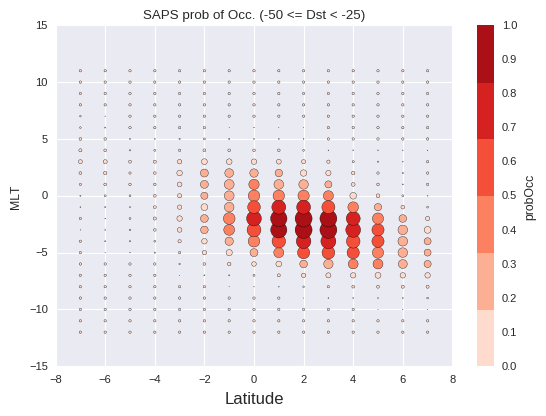

In [8]:
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
sapsSubsetDF.plot( kind='scatter',
              x='normLAT',
              y='normMLT',
              c='probOcc',
              s=sapsSubsetDF["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax)
ax.set_ylabel("MLT")
ax.set_xlabel("Latitude", fontsize=12)
ax.set_title( "SAPS prob of Occ. (-50 <= Dst < -25)" )

# plt.yticks(saps5075["normMLT"].unique(), saps5075["MLT"].unique())
ax.get_figure().savefig("../figs/dstSubsetprob.pdf",bbox_inches='tight')

In [9]:
sapsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in sapsDataDF['sapsMLTRounded']]
sapsDataDF['normLAT'] = [x-57.5 for x in sapsDataDF['sapsLat']]

In [10]:
def saps_fit_func((x, y, dst), a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta):
    
    sigma_x = a_sx + b_sx * dst
    sigma_y = a_sy + b_sy * dst
    xo = a_xo + b_xo * dst
    yo = a_yo + b_yo * dst
    amplitude = a_o + b_o * dst    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [11]:
initGuess = ( 2.93, 2.67e-3, 2.21e-1, 3e-3, 3.86, 6.03e-2, -0.51, 5.57e-2, 0.985, 0.93e-3, 0.633 )#(3,0.001,2,0.001,4,0.05,-0.5,0.05,1,0.001,1)
popt2, pcov2 = curve_fit(saps_fit_func, (sapsModelDF['normLAT'].T,sapsModelDF['normMLT'].T,sapsModelDF['dst_median'].T), sapsModelDF['probOcc'],
                       p0=initGuess)
print popt2

[  3.10884229e+00   3.70593169e-03   1.71954454e+00  -8.19048453e-04
   4.59700276e+00   6.33397164e-02  -1.19425747e+00   3.20730953e-02
   8.42612346e-01  -1.46602321e-03   6.92881089e-01]


In [12]:
def saps_pred_func(x, y, dst):    
    (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
        ( 3.11, 3.71e-03, 1.72,\
             -8.19e-04, 4.59, 6.33e-02, -1.19, 3.21e-02,
             8.93e-01, -1.47e-03, 6.92e-01)
#         ( 3.04, 2.98e-03, 1.69,\
#          -8.53e-04, 4.61, 6.36e-02, -1.28, 3.1e-02,
#          8.49e-01, -1.57e-03, 6.69e-01)        
    sigma_x = a_sx + b_sx * dst
    sigma_y = a_sy + b_sy * dst
    xo = a_xo + b_xo * dst
    yo = a_yo + b_yo * dst
    amplitude = a_o + b_o * dst    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g

In [13]:
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstValArr = []
dstBinArr = []

for z in range( len( sapsModelDF["dst_median"].unique() ) ):
    for x in range( int(sapsModelDF["normLAT"].min()), int(sapsModelDF["normLAT"].max()) + 1 ):
        for y in range( int(sapsModelDF["normMLT"].min()), int(sapsModelDF["normMLT"].max()) + 1 ):        
            normLatArr.append( x )
            normMltArr.append( y )
            if y > 0:
                mltArr.append( y )
            else:
                mltArr.append( y + 24 )
            latArr.append( x + 57.5 )
            currDstVal = sapsModelDF["dst_median"].unique()[z]
            probSapsArr.append( saps_pred_func(x,y,currDstVal) )
            dstValArr.append(currDstVal)
            dstBinArr.append( sapsModelDF["dst_bin"].unique()[z] )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstValArr
sapsPredDF["dst_bin"] = dstBinArr

sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index,dst_bin
0,-12,-7,7.475752e-07,12,50.5,-95.0,"(-150, -75]"
1,-11,-7,6.800314e-06,13,50.5,-95.0,"(-150, -75]"
2,-10,-7,4.880768e-05,14,50.5,-95.0,"(-150, -75]"
3,-9,-7,2.763965e-04,15,50.5,-95.0,"(-150, -75]"
4,-8,-7,1.234986e-03,16,50.5,-95.0,"(-150, -75]"


In [14]:
# rename columns for ease of comparison
sapsPredDF.columns = [ "pred_normMLT", "pred_normLAT", "pred_prob", "pred_MLT", "pred_Lat", "pred_dst", "pred_dst_bin" ]
# # join the two dataframes and find the difference between pred and actual prob 
sapsModelDF = pandas.merge( sapsModelDF, sapsPredDF, left_on=[ "normMLT", "normLAT", "dst_median" ],\
                           right_on=[ "pred_normMLT", "pred_normLAT", "pred_dst" ] )
# sapsModelDF = sapsModelDF["pred_normMLT", "pred_normLAT", "pred_prob", "probOcc"]
sapsModelDF.drop( [ "normMLT", "normLAT", "MLT_x", "Lat", \
                   "dst_bin", "sapsMLT", "sapsLat",\
                   "probSAPS", "MLT_y"], axis=1, inplace=True )
# # get the difference
sapsModelDF["prob_diff"] = sapsModelDF["pred_prob"] - sapsModelDF["probOcc"]
sapsModelDF["stringMLT"] = sapsModelDF["pred_MLT"].map(lambda x: str(x) )

sapsModelDF.head()

,dataCount_x,maxCount_x,dst_median,dataCount_y,maxCount_y,probOcc,pred_normMLT,pred_normLAT,pred_prob,pred_MLT,pred_Lat,pred_dst,pred_dst_bin,prob_diff,stringMLT
0,NaN,NaN,-95.0,NaN,NaN,0.020000,0,-7,0.038705,24,50.5,-95.0,"(-150, -75]",0.018705,24
1,NaN,NaN,-95.0,NaN,NaN,0.020000,1,-7,0.020496,1,50.5,-95.0,"(-150, -75]",0.000496,1
2,NaN,NaN,-95.0,2.0,333.0,0.006006,2,-7,0.008563,2,50.5,-95.0,"(-150, -75]",0.002557,2
3,NaN,NaN,-95.0,5.0,333.0,0.015015,3,-7,0.002823,3,50.5,-95.0,"(-150, -75]",-0.012192,3
4,NaN,NaN,-95.0,2.0,333.0,0.006006,4,-7,0.000734,4,50.5,-95.0,"(-150, -75]",-0.005272,4


In [15]:
# Select a subset data for plotting actual and pred values
sapsSubsetPlot = sapsModelDF[ sapsModelDF["pred_dst_bin"] == "(-50, -25]" ].reset_index(drop=True)
sapsSubsetPlot["prob_diff"] = [0.005 if abs(x) <= 0.01 else x for x in sapsSubsetPlot['prob_diff']]

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


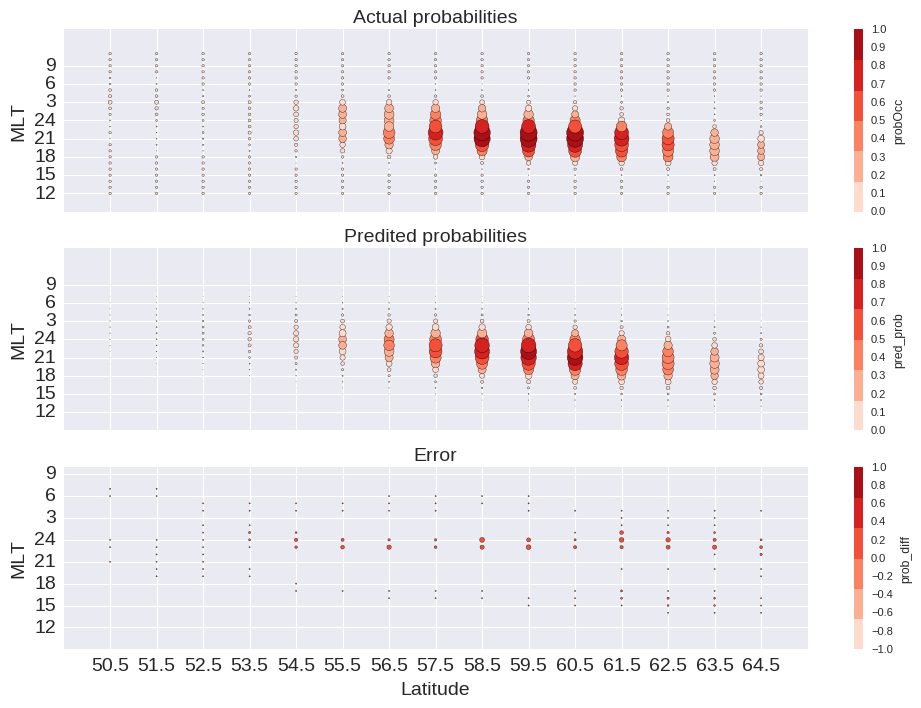

In [16]:
# Make a comparison plot of the data
# the model, actual values and error
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,1,1)
ax2 = f.add_subplot(3,1,2)
ax3 = f.add_subplot(3,1,3)
# plt.tick_params(axis='both', which='major', labelsize=16)
# f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# sns.set_style("darkgrid")
# sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Actual prob values


sapsSubsetPlot.plot( kind='scatter',
              x='pred_normLAT',
              y='pred_normMLT',
              c='probOcc',
              s=sapsSubsetPlot["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax1, sharex=True)
ax1.set_ylabel("MLT", fontsize=14)
ax1.set_xlabel("Latitude", fontsize=14)
ax1.set_title( "Actual probabilities", fontsize=14 )
ax1.set_yticks( sapsSubsetPlot["pred_normMLT"].unique()[0:-1:3] )
ax1.set_yticklabels(sapsSubsetPlot["stringMLT"].unique()[0:-1:3], fontsize=1)
ax1.set_xticks( sapsSubsetPlot["pred_normLAT"].unique() )
ax1.set_xticklabels(sapsSubsetPlot["pred_Lat"].unique())
ax1.tick_params(axis='both', which='major', labelsize=14)
# ax1.yaxis.major.locator.set_params(nbins=10) 

# Predicted prob values
sapsSubsetPlot.plot( kind='scatter',
              x='pred_normLAT',
              y='pred_normMLT',
              c='pred_prob',
              s=sapsSubsetPlot["pred_prob"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax2, sharex=True)
ax2.set_ylabel("MLT", fontsize=14)
ax2.set_xlabel("Latitude", fontsize=14)
ax2.set_title( "Predited probabilities", fontsize=14 )
ax2.set_yticks( sapsSubsetPlot["pred_normMLT"].unique()[0:-1:3] )
ax2.set_yticklabels(sapsSubsetPlot["stringMLT"].unique()[0:-1:3], fontsize=1)
ax2.set_xticks( sapsSubsetPlot["pred_normLAT"].unique() )
ax2.set_xticklabels(sapsSubsetPlot["pred_Lat"].unique())
ax2.tick_params(axis='both', which='major', labelsize=14)
# difference between actual and pred values (error)
sapsSubsetPlot.plot( kind='scatter',
              x='pred_normLAT',
              y='pred_normMLT',
              c='prob_diff',
              s=sapsSubsetPlot["prob_diff"]*150, cmap=seaMap, vmin=-1, vmax=1, ax=ax3)
ax3.set_ylabel("MLT", fontsize=14)
ax3.set_xlabel("Latitude", fontsize=14)
ax3.set_title( "Error", fontsize=14 )
ax3.set_yticks( sapsSubsetPlot["pred_normMLT"].unique()[0:-1:3] )
ax3.set_yticklabels(sapsSubsetPlot["stringMLT"].unique()[0:-1:3])
ax3.set_xticks( sapsSubsetPlot["pred_normLAT"].unique() )
ax3.set_xticklabels(sapsSubsetPlot["pred_Lat"].unique())
ax3.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../figs/probsModelComp-new.pdf",bbox_inches='tight')

In [17]:
# Most likely location plot for dst_bin and MLT
mostLikelyMLTLatLoc = sapsModelDF.groupby( ["pred_dst_bin", "pred_MLT"] ).max().reset_index()
mostLikelyMLTLatLoc = mostLikelyMLTLatLoc[ ["pred_dst_bin", "pred_MLT", "probOcc"] ]
mostLikelyMLTLatLoc = mostLikelyMLTLatLoc[ mostLikelyMLTLatLoc["probOcc"] >= 0.25 ]
mostLikelyMLTLatLoc.reset_index(inplace=True,drop=True)
mostLikelyMLTLatLoc = pandas.merge( mostLikelyMLTLatLoc, sapsModelDF,\
                                   on=["pred_dst_bin", "pred_MLT", "probOcc"], how="inner")
# mostLikelyMLTLatLoc = mostLikelyMLTLatLoc[ ["pred_dst_bin", "pred_MLT", "probOcc", "pred_Lat",\
#                                            "pred_normMLT", "pred_normLAT"] ]
mostLikelyMLTLatLoc.loc[mostLikelyMLTLatLoc['pred_MLT'] == 24, 'pred_MLT'] = 0
mostLikelyMLTLatLoc["mltStr"] = mostLikelyMLTLatLoc["pred_MLT"].map(lambda x: str(int(x)))
mostLikelyMLTLatLoc[mostLikelyMLTLatLoc["mltStr"] == "0"].head()
# # mostLikelyMLTLatLoc[mostLikelyMLTLatLoc["stringMLT"] == "24"] = "0"
# sapsModelDF[(sapsModelDF["pred_MLT"] == 24) & (sapsModelDF["probOcc"] > 0.25)].head()





# mostLikelyMLTLatLoc = mostLikelyMLTLatLoc.drop(["dst_median_x", "probOcc_y",\
#                         "probOcc_x", "pred_normMLT_x", "pred_normLAT_x", "pred_prob_x",\
#                         "pred_Lat_y", "pred_dst_x", "prob_diff_x","stringMLT_x", "stringMLT_y",\
#                         "dst_median_y", "prob_diff_y", "pred_dst_y", "pred_prob_y",\
#                         "pred_normMLT_y","pred_normLAT_y"], 1)
# mostLikelyMLTLatLoc.columns = [ "dst_bin", "MLT", "Lat" ]
# mostLikelyMLTLatLoc.drop_duplicates(inplace=True)

,pred_dst_bin,pred_MLT,probOcc,dataCount_x,maxCount_x,dst_median,dataCount_y,maxCount_y,pred_normMLT,pred_normLAT,pred_prob,pred_Lat,pred_dst,prob_diff,stringMLT,mltStr
7,"(-10, 10]",0,0.713186,NaN,NaN,-5.0,741.0,1039.0,0,4,0.705944,61.5,-5.0,-0.007241,24,0
23,"(-25, -10]",0,0.611781,NaN,NaN,-18.0,1319.0,2156.0,0,3,0.638359,60.5,-18.0,0.026578,24,0
32,"(-50, -25]",0,0.458973,NaN,NaN,-36.0,867.0,1889.0,0,0,0.480162,57.5,-36.0,0.021189,24,0
39,"(-75, -50]",0,0.270492,NaN,NaN,-57.0,165.0,610.0,0,-1,0.380717,56.5,-57.0,0.110225,24,0


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:3430: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


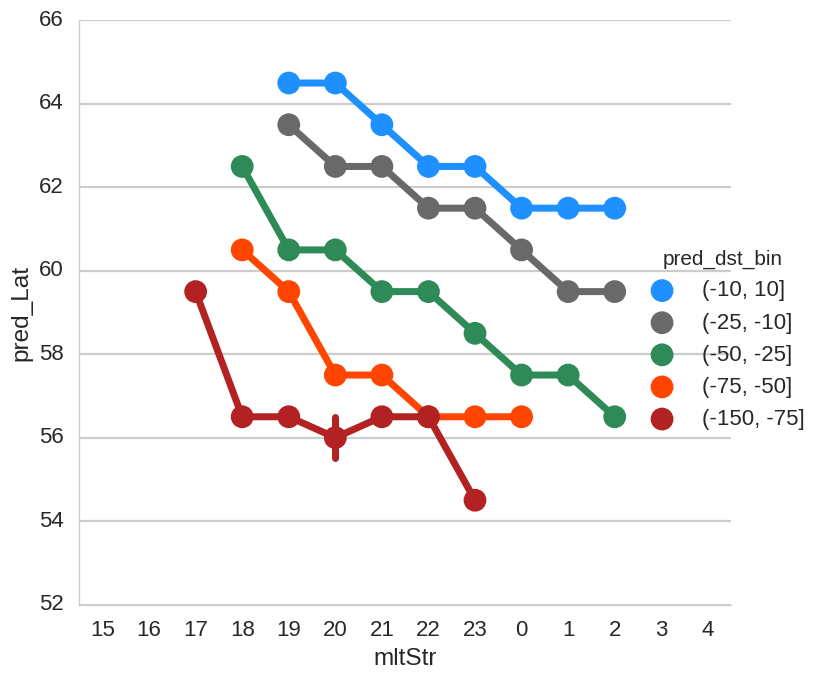

In [18]:
sns.set_style("whitegrid")
sns.set_context("poster")
# seaborn.palplot(seaborn.light_palette((210, 90, 60), input="husl"))


# parameters for plot
mltOrder = [ "15", "16", "17", "18", "19",\
            "20", "21", "22", "23", "0", "1", "2", "3", "4" ]
hue_order=[ '(-150, -75]','(-75, -50]','(-50, -25]', '(-25, -10]', '(-10, 10]' ]
colors = ["dodgerblue","dimgray","seagreen","orangered", "firebrick" ]

mllFig = sns.factorplot(x="mltStr", y="pred_Lat", hue="pred_dst_bin", \
                    data=mostLikelyMLTLatLoc, hue_order=hue_order[::-1], \
                   x_order=mltOrder, size=5, aspect=3,\
                   palette=sns.color_palette(colors), legend_out=True, kind="point")
fig2 = mllFig.fig
fig2.set_size_inches(8,8)
fig2.savefig("../figs/mostLikelyLoc-new.pdf",bbox_inches='tight')# parameters for plot

In [19]:
meanLatLocDF = sapsModelDF[ sapsModelDF["probOcc"] > 0.25 ].groupby(\
                            ["pred_dst_bin", "pred_MLT"] ).mean().reset_index()
stdLatLocDF = sapsModelDF[ sapsModelDF["probOcc"] > 0.25 ].groupby(\
                            ["pred_dst_bin", "pred_MLT"] ).std().reset_index()
meanLatLocDF = meanLatLocDF[ ["dataCount_y", "maxCount_y", "probOcc",\
                              "pred_MLT", "pred_Lat", "pred_dst_bin"] ]
stdLatLocDF = stdLatLocDF[ ["pred_MLT", "pred_Lat", "pred_dst_bin"] ]
stdLatLocDF.columns = ["pred_MLT", "std_Lat", "pred_dst_bin"]
meanLatLocDF = pandas.merge( meanLatLocDF,  stdLatLocDF, on=["pred_MLT", "pred_dst_bin"])
meanLatLocDF.loc[meanLatLocDF['pred_MLT'] == 24, 'pred_MLT'] = 0

meanLatLocDF["mltStr"] = meanLatLocDF["pred_MLT"].map(lambda x: str(int(x)))
meanLatLocDF.head()

,dataCount_y,maxCount_y,probOcc,pred_MLT,pred_Lat,pred_dst_bin,std_Lat,mltStr
0,488.666667,1039.0,0.470324,1,60.0,"(-10, 10]",1.870829,1
1,380.666667,1039.0,0.366378,2,60.0,"(-10, 10]",1.870829,2
2,276.000000,1039.0,0.265640,19,64.5,"(-10, 10]",NaN,19
3,391.666667,1039.0,0.376965,20,63.5,"(-10, 10]",1.000000,20
4,516.200000,1039.0,0.496824,21,62.5,"(-10, 10]",1.581139,21


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


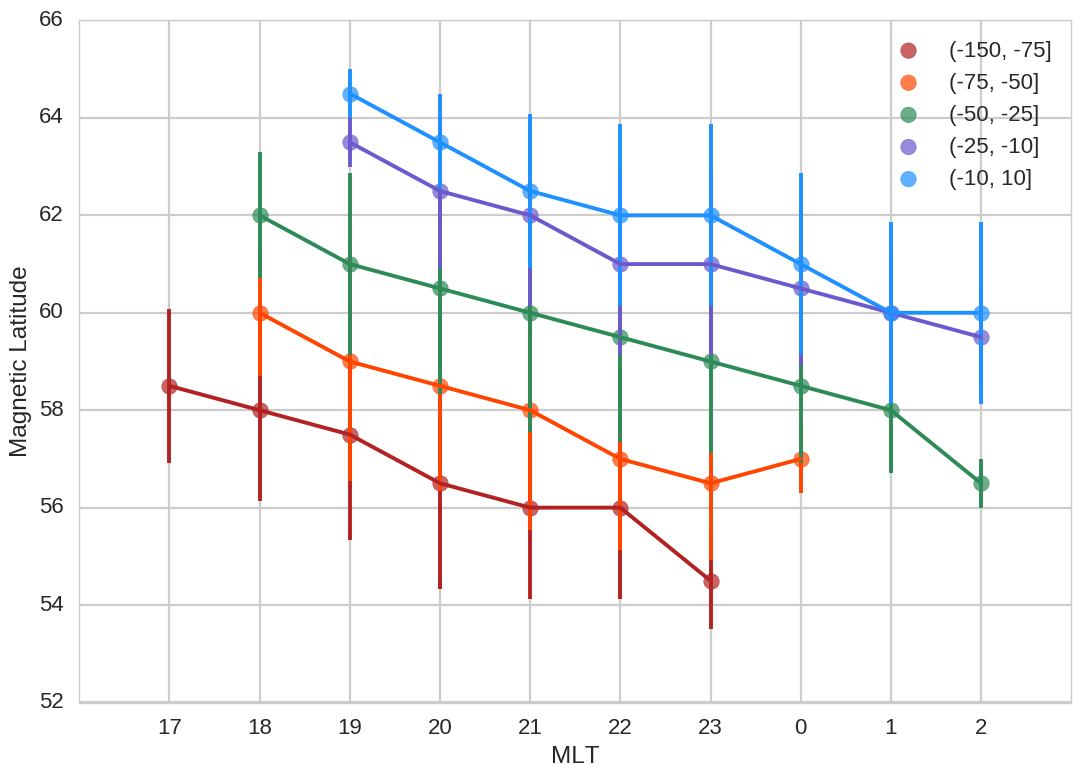

In [20]:
sns.set_style("whitegrid")
sns.set_context("poster")

meanLatLocDF['normMLT'] = [x-24 if x >= 12 else x for x in meanLatLocDF['pred_MLT']]
meanLatLocDF["std_Lat"] = meanLatLocDF["std_Lat"].fillna(0.5)
meanLatLocDF = meanLatLocDF.sort(["normMLT"])
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-150, -75]"],
            meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-150, -75]')
plt.errorbar(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-150, -75]"],\
             meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-150, -75]"],\
             yerr=meanLatLocDF['std_Lat'][meanLatLocDF['pred_dst_bin'] == "(-150, -75]"], \
             color='firebrick', label='')
# plt.xticks(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-150, -75]"], \
#            meanLatLocDF['mltStr'][meanLatLocDF['pred_dst_bin'] == "(-150, -75]"], size='small')

# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
           
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-75, -50]"],
            meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
plt.errorbar(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-75, -50]"],\
             meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-75, -50]"],\
             yerr=meanLatLocDF['std_Lat'][meanLatLocDF['pred_dst_bin'] == "(-75, -50]"],\
             color='orangered', label='')
# plt.xticks(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-75, -50]"], \
#            meanLatLocDF['mltStr'][meanLatLocDF['pred_dst_bin'] == "(-75, -50]"], size='small')

###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######

###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######

plt.scatter(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-50, -25]"],
            meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-50, -25]')

plt.errorbar(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-50, -25]"],\
             meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-50, -25]"],\
             yerr=meanLatLocDF['std_Lat'][meanLatLocDF['pred_dst_bin'] == "(-50, -25]"],\
             color='seagreen', label='')
# plt.xticks(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-50, -25]"], \
#            meanLatLocDF['mltStr'][meanLatLocDF['pred_dst_bin'] == "(-50, -25]"], size='small')

###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######

###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
meanLatLocDF['normMLT'] = [x-24 if x >= 12 else x for x in meanLatLocDF['pred_MLT']]
# meanLatLocDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-25, -10]"],
            meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
plt.errorbar(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-25, -10]"],\
             meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-25, -10]"],\
             yerr=meanLatLocDF['std_Lat'][meanLatLocDF['pred_dst_bin'] == "(-25, -10]"], \
             color='slateblue', label='')
# plt.xticks(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-25, -10]"], \
#            meanLatLocDF['mltStr'][meanLatLocDF['pred_dst_bin'] == "(-25, -10]"], size='small')
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
meanLatLocDF['normMLT'] = [x-24 if x >= 12 else x for x in meanLatLocDF['pred_MLT']]
# meanLatLocDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-10, 10]"],
            meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(meanLatLocDF['normMLT'][meanLatLocDF['pred_dst_bin'] == "(-10, 10]"],\
             meanLatLocDF['pred_Lat'][meanLatLocDF['pred_dst_bin'] == "(-10, 10]"],\
             yerr=meanLatLocDF['std_Lat'][meanLatLocDF['pred_dst_bin'] == "(-10, 10]"], \
             color='dodgerblue', label='')
plt.xticks(meanLatLocDF['normMLT'].unique(), \
           meanLatLocDF['mltStr'].unique(), size='small')
plt.xlim( [-8,3] )
plt.xlabel("MLT")
plt.ylabel("Magnetic Latitude")
plt.legend()
plt.savefig("../figs/meanStdLatLoc-new.pdf",bbox_inches='tight')
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######

In [21]:
# Write the probabilities to a text file for use in IDL
sapsModelDF = sapsModelDF[ [ "dst_median", "dataCount_y", "maxCount_y",\
                            "probOcc", "pred_prob", "pred_MLT", "pred_Lat" ] ]
sapsModelDF["probOcc"] = sapsModelDF["probOcc"].map( lambda x: round(x,2) )
sapsModelDF["pred_prob"] = sapsModelDF["pred_prob"].map( lambda x: round(x,2) )
sapsModelDF.to_csv("../data/sapsProb-Models.txt", sep=' ', index=False)